## ARCHITECTURES ##

In [54]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image

In [31]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


**DATASET PREPARATION**

In [32]:
# Dataset Transformation: Resize to 45x45 and convert to grayscale
transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Resize all images to 28x28
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize for single channel (grayscale)
])

# Load Dataset using ImageFolder
dataset = datasets.ImageFolder(root='/kaggle/input/dataset/MatricesTest2014', transform=transform)

# Check Class to Index Mapping
print("Class to Index Mapping:", dataset.class_to_idx)

# Split Dataset into Training and Validation Sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# DataLoader for Training and Validation
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)


Class to Index Mapping: {'(': 0, ')': 1, '+': 2, '-': 3, '0': 4, '1': 5, '2': 6, '3': 7, '4': 8, '5': 9, '6': 10, '7': 11, '8': 12, '9': 13, '=': 14, 'a': 15, 'alpha': 16, 'b': 17, 'beta': 18, 'bigBrackClose': 19, 'bigBrackOpen': 20, 'c': 21, 'capital_A': 22, 'capital_B': 23, 'capital_C': 24, 'capital_F': 25, 'capital_G': 26, 'capital_H': 27, 'capital_I': 28, 'capital_K': 29, 'capital_M': 30, 'capital_N': 31, 'capital_P': 32, 'capital_R': 33, 'capital_S': 34, 'capital_T': 35, 'd': 36, 'delta': 37, 'epsilon': 38, 'exists': 39, 'f': 40, 'forall': 41, 'g': 42, 'gamma': 43, 'geq': 44, 'gt': 45, 'h': 46, 'i': 47, 'idots': 48, 'infinity': 49, 'k': 50, 'lambda': 51, 'leq': 52, 'limit': 53, 'log': 54, 'lt': 55, 'mathsfunctions': 56, 'mu': 57, 'multiply': 58, 'neq': 59, 'numbers': 60, 'o': 61, 'operations': 62, 'p': 63, 'phi': 64, 'pie': 65, 'pm': 66, 'q': 67, 'r': 68, 'rightarrorw': 69, 's': 70, 'sigma': 71, 'sin': 72, 'sum': 73, 't': 74, 'tan': 75, 'theta': 76, 'times': 77, 'u': 78, 'v': 79, 

In [33]:
# Define Training Function
def train_model(model, criterion, optimizer, train_loader, num_epochs=5):
    model.train()  # Set model to training mode

    for epoch in range(num_epochs):
        running_loss = 0.0  # To track loss per epoch

        for inputs, labels in train_loader:
            # Move inputs and labels to device (CPU/GPU)
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass: compute predictions
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels)

            # Backward pass: compute gradients
            loss.backward()

            # Update weights
            optimizer.step()

            # Accumulate loss
            running_loss += loss.item()

        # Print epoch loss
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

# Define Validation Function
def validate_model(model, val_loader):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient computation
        for inputs, labels in val_loader:
            # Move inputs and labels to device
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)  # Get class with highest score

            # Update total and correct counts
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Compute and print accuracy
    accuracy = 100 * correct / total
    # print(f'Validation Accuracy: {accuracy:.2f}%')
    return accuracy


**HERE ARE 6 DIFFERENT ARCHITECTURES OF CNN**

In [34]:
class LightweightCNN(nn.Module):
    def __init__(self):
        super(LightweightCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=3)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=3)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(3 * 3 * 32, 512)
        self.fc2 = nn.Linear(512, 84)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        return self.fc2(x)


In [35]:
# Define the model (SimpleCNN)
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        # Adjusted for grayscale images
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)  # Input: 28x28, Output: 28x28
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=3)  # Reducing size from 28x28 to 9x9

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)  # Input: 9x9, Output: 9x9
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=3)  # Reducing size from 9x9 to 3x3

        self.flatten = nn.Flatten()  # Flattening Layer
        self.fc1 = nn.Linear(in_features=3 * 3 * 64, out_features=1024)  # Fully connected layer
        self.dropout = nn.Dropout(p=0.4)  # Dropout layer
        self.fc2 = nn.Linear(in_features=1024, out_features=84)  # Output layer with 84 classes

    def forward(self, x):
        x = torch.relu(self.conv1(x))  # Convolutional layer 1 followed by ReLU
        x = self.pool1(x)              # Max-pooling layer 1

        x = torch.relu(self.conv2(x))  # Convolutional layer 2 followed by ReLU
        x = self.pool2(x)              # Max-pooling layer 2

        x = self.flatten(x)            # Flattening layer
        x = torch.relu(self.fc1(x))    # Fully connected layer 1 followed by ReLU
        x = self.dropout(x)            # Dropout layer

        x = self.fc2(x)                # Output layer (4 classes)
        return x


In [25]:
class ModifiedSimpleCNN(nn.Module):
    def __init__(self):
        super(ModifiedSimpleCNN, self).__init__()
        
        # First Convolution Block
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # Output: (32, 28, 28)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: (32, 14, 14)
        
        # Second Convolution Block
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # Output: (64, 14, 14)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: (64, 7, 7)
        
        # Third Convolution Block (no pooling here)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # Output: (128, 7, 7)
        self.bn3 = nn.BatchNorm2d(128)
        
        # Flatten and Fully Connected Layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(7 * 7 * 128, 1024)  # Adjusted for the flattened output size
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(1024, 84)  # Final output layer
    
    def forward(self, x):
        x = self.pool1(self.bn1(nn.ReLU()(self.conv1(x))))
        x = self.pool2(self.bn2(nn.ReLU()(self.conv2(x))))
        x = nn.ReLU()(self.bn3(self.conv3(x)))
        x = self.flatten(x)
        x = nn.ReLU()(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [36]:
class ResNetInspired(nn.Module):
    def __init__(self):
        super(ResNetInspired, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        # First Residual Block
        self.res_block1 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32)
        )

        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=3)

        # Second Residual Block
        self.res_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64)
        )

        # 1x1 convolution to match dimensions if needed for the residual
        self.conv1x1 = nn.Conv2d(32, 64, kernel_size=1)

        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=3)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(3 * 3 * 64, 1024)
        self.fc2 = nn.Linear(1024, 84)

    def forward(self, x):
        # Initial Convolution
        x = F.relu(self.bn1(self.conv1(x)))

        # First Residual Block
        residual = x
        x = self.res_block1(x)
        x += residual  # Adding residual
        x = F.relu(x)

        # First Pooling
        x = self.pool1(x)

        # Second Residual Block
        residual = x
        x = self.res_block2(x)

        # Adjust residual dimensions with 1x1 convolution if needed
        if residual.shape[1] != x.shape[1]:
            residual = self.conv1x1(residual)

        x += residual  # Adding adjusted residual
        x = F.relu(x)

        # Second Pooling
        x = self.pool2(x)
        x = self.flatten(x)

        # Fully Connected Layers
        x = F.relu(self.fc1(x))
        return self.fc2(x)


In [37]:
class DenseNetInspired(nn.Module):
    def __init__(self):
        super(DenseNetInspired, self).__init__()
        
        # Initial Convolution
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # Output: (32, 28, 28)
        
        # First Dense Block
        self.dense_block1 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, padding=1),  # Output: (32, 28, 28)
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),  # Output: (32, 28, 28)
            nn.ReLU()
        )
        
        # Transition Layer 1
        self.transition1 = nn.Conv2d(64, 64, kernel_size=1)  # Output: (64, 28, 28)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: (64, 14, 14)
        
        # Second Dense Block
        self.dense_block2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),  # Output: (64, 14, 14)
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),  # Output: (64, 14, 14)
            nn.ReLU()
        )
        
        # Transition Layer 2
        self.transition2 = nn.Conv2d(128, 128, kernel_size=1)  # Output: (128, 14, 14)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: (128, 7, 7)
        
        # Fully Connected Layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(7 * 7 * 128, 1024)  # Adjusted to match output size
        self.fc2 = nn.Linear(1024, 84)

    def forward(self, x):
        # Initial Convolution
        x = F.relu(self.conv1(x))
        
        # First Dense Block with concatenation
        x1 = self.dense_block1(x)
        x = torch.cat([x, x1], 1)  # Dense connection (channels increased from 32 to 64)
        x = self.pool1(self.transition1(x))  # Transition and Pooling
        
        # Second Dense Block with concatenation
        x2 = self.dense_block2(x)
        x = torch.cat([x, x2], 1)  # Dense connection (channels increased from 64 to 128)
        x = self.pool2(self.transition2(x))  # Transition and Pooling
        
        # Flatten and Fully Connected Layer
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        return self.fc2(x)


In [48]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

def plot_class_distribution(true_labels, predicted_labels):
    """
    Plots the number of samples per class and the number of correctly predicted samples per class.

    Args:
        true_labels (list or np.array): Array of true class labels.
        predicted_labels (list or np.array): Array of predicted class labels.
    """
    true_labels = np.array(true_labels)  # Convert to numpy array if not already
    predicted_labels = np.array(predicted_labels)  # Convert to numpy array if not already

    # Get unique classes and their counts
    classes, class_counts = np.unique(true_labels, return_counts=True)

    # Count the correctly predicted samples per class
    correct_predictions = Counter(true_labels[predicted_labels == true_labels])

    # Prepare data for plotting
    correct_counts = [correct_predictions.get(cls, 0) for cls in classes]

    # Plot the graph
    plt.figure(figsize=(10, 6))
    bar_width = 0.4

    # Create bars for total samples per class
    plt.bar(classes - bar_width / 2, class_counts, bar_width, label="Total Samples", color="skyblue")

    # Create bars for correctly predicted samples per class
    plt.bar(classes + bar_width / 2, correct_counts, bar_width, label="Correctly Predicted", color="green")

    # Add labels and title
    plt.xlabel("Classes", fontsize=12)
    plt.ylabel("Number of Samples", fontsize=12)
    plt.title("Class Distribution and Correct Predictions", fontsize=14)
    plt.xticks(classes)
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

In [49]:
# def evaluate_model(model, model_name, criterion, optimizer, train_loader, val_loader, num_epochs=10):
#     print(f"--- Training {model_name} ---")
#     train_model(model, criterion, optimizer, train_loader, num_epochs)
#     print(f"\n--- Validating {model_name} ---")
#     accuracy = validate_model(model, val_loader)

#     print(f"Validation Accuracy of {model_name}: {accuracy:.2f}%")
#     print("\n" + "-" * 50 + "\n")
    
#     return accuracy

# Function to train, validate, and plot class distributions for each model
def evaluate_and_plot_model(model, model_name, criterion, optimizer, train_loader, val_loader, num_epochs=10):
    print(f"--- Training {model_name} ---")
    train_model(model, criterion, optimizer, train_loader, num_epochs)
    print(f"\n--- Validating {model_name} ---")
    accuracy = validate_model(model, val_loader)
    
    # Collect true and predicted labels
    all_true_labels = []
    all_predicted_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_true_labels.extend(labels.cpu().numpy())  # Convert to numpy
            all_predicted_labels.extend(preds.cpu().numpy())

    # Plot class distribution and predictions
    print(f"--- Plotting Class Distribution for {model_name} ---")
    plot_class_distribution(all_true_labels, all_predicted_labels)
    print("\n" + "-" * 50 + "\n")
    
    return accuracy


In [50]:
# Initialize the models
LightweightCNNmodel = LightweightCNN().to(device)
SimpleCNNmodel = SimpleCNN().to(device)
ModifiedSimpleCNNmodel = ModifiedSimpleCNN().to(device)
ResNetInspiredmodel = ResNetInspired().to(device)
DenseNetInspiredmodel = DenseNetInspired().to(device)

# Iterate over the models
models = {
    "LightweightCNN": LightweightCNNmodel,
    "SimpleCNN": SimpleCNNmodel,
    "ModifiedSimpleCNN": ModifiedSimpleCNNmodel,
    "ResNetInspired": ResNetInspiredmodel,
    "DenseNetInspired": DenseNetInspiredmodel
}

--- Training LightweightCNN ---
Epoch [1/10], Loss: 3.1657
Epoch [2/10], Loss: 1.2888
Epoch [3/10], Loss: 0.7340
Epoch [4/10], Loss: 0.5188
Epoch [5/10], Loss: 0.3954
Epoch [6/10], Loss: 0.3106
Epoch [7/10], Loss: 0.2517
Epoch [8/10], Loss: 0.1989
Epoch [9/10], Loss: 0.1754
Epoch [10/10], Loss: 0.1338

--- Validating LightweightCNN ---
Validation Accuracy: 88.58%
--- Plotting Class Distribution for LightweightCNN ---


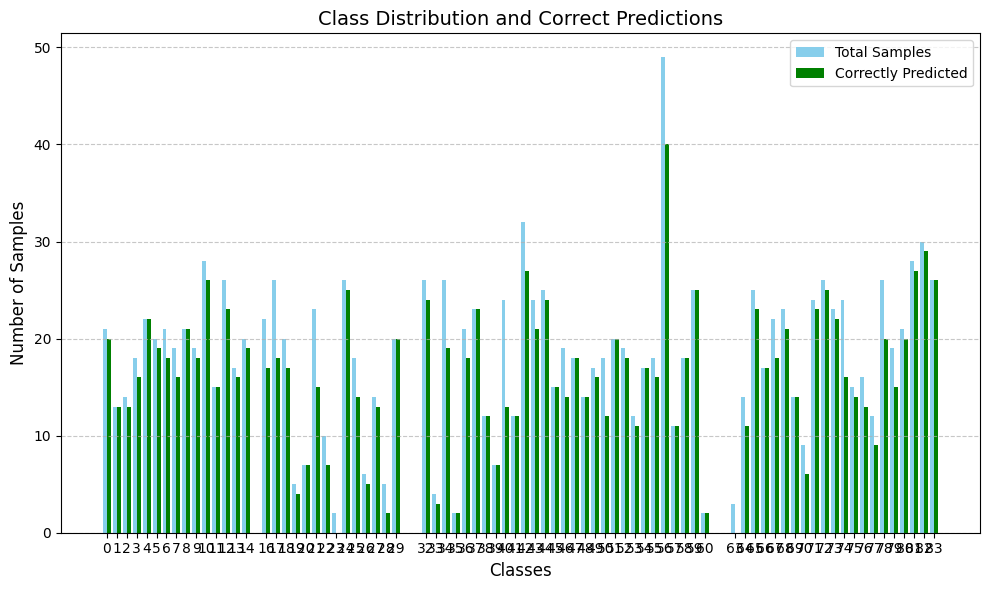


--------------------------------------------------

--- Training SimpleCNN ---
Epoch [1/10], Loss: 2.9588
Epoch [2/10], Loss: 0.9800
Epoch [3/10], Loss: 0.5889
Epoch [4/10], Loss: 0.4273
Epoch [5/10], Loss: 0.3476
Epoch [6/10], Loss: 0.2520
Epoch [7/10], Loss: 0.2346
Epoch [8/10], Loss: 0.1845
Epoch [9/10], Loss: 0.1627
Epoch [10/10], Loss: 0.1287

--- Validating SimpleCNN ---
Validation Accuracy: 89.41%
--- Plotting Class Distribution for SimpleCNN ---


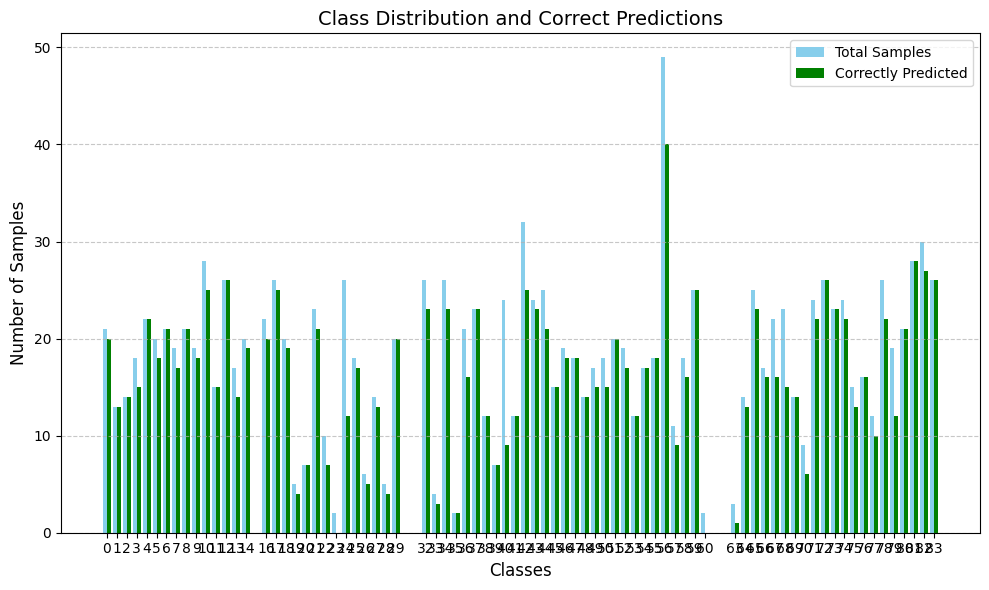


--------------------------------------------------

--- Training ModifiedSimpleCNN ---
Epoch [1/10], Loss: 1.8876
Epoch [2/10], Loss: 0.6727
Epoch [3/10], Loss: 0.4957
Epoch [4/10], Loss: 0.3582
Epoch [5/10], Loss: 0.2590
Epoch [6/10], Loss: 0.2244
Epoch [7/10], Loss: 0.1454
Epoch [8/10], Loss: 0.1619
Epoch [9/10], Loss: 0.1279
Epoch [10/10], Loss: 0.1244

--- Validating ModifiedSimpleCNN ---
Validation Accuracy: 92.87%
--- Plotting Class Distribution for ModifiedSimpleCNN ---


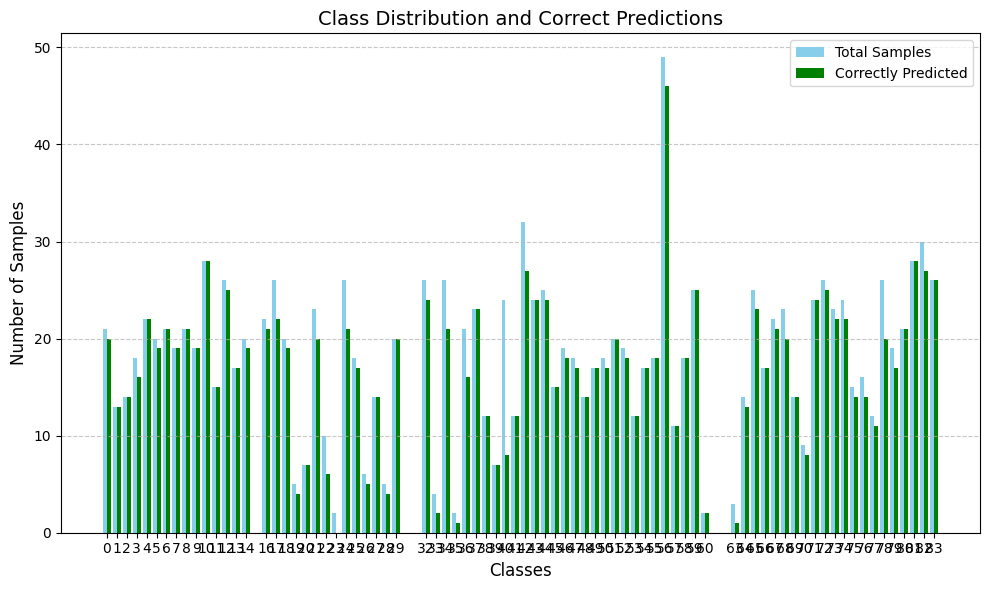


--------------------------------------------------

--- Training ResNetInspired ---
Epoch [1/10], Loss: 1.7946
Epoch [2/10], Loss: 0.4358
Epoch [3/10], Loss: 0.2568
Epoch [4/10], Loss: 0.1653
Epoch [5/10], Loss: 0.1146
Epoch [6/10], Loss: 0.0890
Epoch [7/10], Loss: 0.0632
Epoch [8/10], Loss: 0.0562
Epoch [9/10], Loss: 0.0459
Epoch [10/10], Loss: 0.0424

--- Validating ResNetInspired ---
Validation Accuracy: 92.18%
--- Plotting Class Distribution for ResNetInspired ---


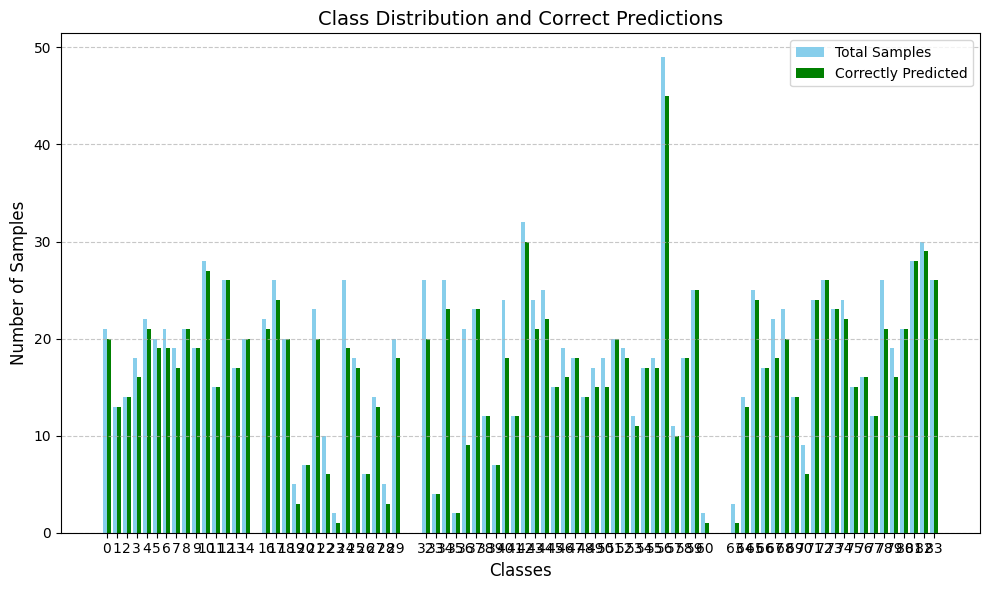


--------------------------------------------------

--- Training DenseNetInspired ---
Epoch [1/10], Loss: 1.8137
Epoch [2/10], Loss: 0.4972
Epoch [3/10], Loss: 0.2337
Epoch [4/10], Loss: 0.1443
Epoch [5/10], Loss: 0.1314
Epoch [6/10], Loss: 0.0747
Epoch [7/10], Loss: 0.0551


In [ ]:
# Initialize a dictionary to store the validation accuracy for each model
accuracies = {}

# Iterate over the models and collect accuracy
for model_name, model in models.items():
    # Reinitialize optimizer for each model to avoid weight conflicts
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Train and validate the model, storing the validation accuracy
    accuracy = evaluate_and_plot_model(model, model_name, criterion, optimizer, train_loader, val_loader, num_epochs=10)
    accuracies[model_name] = accuracy


In [ ]:
# Plotting the accuracy data
def plot_accuracies(accuracies):
    model_names = list(accuracies.keys())
    accuracy_values = list(accuracies.values())

    plt.figure(figsize=(10, 6))
    plt.barh(model_names, accuracy_values, color='skyblue')
    plt.xlabel('Accuracy (%)')
    plt.title('Model Validation Accuracy')
    plt.xlim(0, 100)  # Accuracy should be between 0 and 100
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    # Display accuracy values on the bars
    for index, value in enumerate(accuracy_values):
        plt.text(value + 1, index, f'{value:.2f}%', va='center')

    plt.show()

# Plot the accuracies using the collected data
plot_accuracies(accuracies)


## Prediction on real image

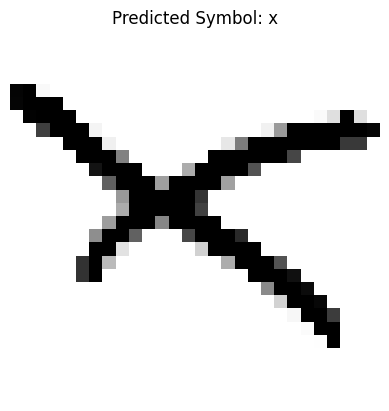

Predicted class: 81


In [61]:
idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}

# Function to load image and make a prediction
def predict_image(image_path, model, transform):
    # Load the image using PIL
    img = Image.open(image_path).convert('RGB')
    
    # Apply transformations
    img_tensor = transform(img).unsqueeze(0)  # Add batch dimension: shape becomes (1, 1, 28, 28)
    
    # Move the image tensor to the device (GPU or CPU)
    img_tensor = img_tensor.to(device)
    
    # Set the model to evaluation mode
    model.eval()
    
    # Predict the class
    with torch.no_grad():
        outputs = model(img_tensor)  # Forward pass
        _, predicted_class = torch.max(outputs, 1)  # Get the class with the highest score
    
    # Convert the predicted class to a human-readable format (for example, class names or indices)
    predicted_class = predicted_class.item()  # Convert tensor to Python number
    # Show the image and predicted output
    plt.imshow(img)
    plt.title(f"Predicted Symbol: {idx_to_class[predicted_class]}")
    plt.axis('off')  # Hide axis
    plt.show()
    
    return predicted_class

# Example usage
image_path = "/kaggle/input/dataset/MatricesTest2014/x/10.png"
predicted_class = predict_image(image_path, ModifiedSimpleCNNmodel, transform)
print(f"Predicted class: {predicted_class}")

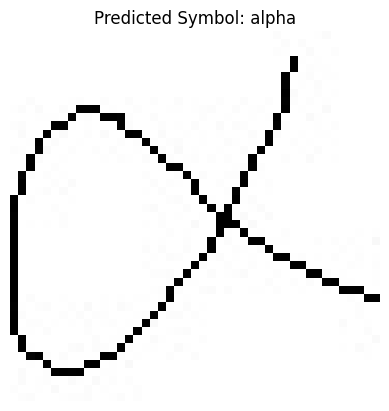

Predicted class: 16


In [62]:
image_path = "/kaggle/input/dataset/MatricesTest2014/alpha/alpha_76733.jpg"
predicted_class = predict_image(image_path, ModifiedSimpleCNNmodel, transform)
print(f"Predicted class: {predicted_class}")